In [94]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

import joblib

Load the dataset and check its shape.

In [95]:
names = ['intercolumnar distance', 'upper margin', 
         'lower margin', 'exploitation', 'row number', 
         'modular ratio', 'interlinear spacing', 'weight', 
         'peak number', 'modular ratio/ interlinear spacing', 'class']
avila_test = pd.read_csv('avila-ts.txt', header = None, names = names)
avila_test.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,class
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A


In [96]:
avila_test.shape

(10437, 11)

In [97]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = snapshot(avila_test)
snapshot

,n_unique,dtype,n_missing,pct_missing
intercolumnar distance,143,float64,0,0.0
upper margin,204,float64,0,0.0
lower margin,230,float64,0,0.0
exploitation,748,float64,0,0.0
row number,47,float64,0,0.0
modular ratio,234,float64,0,0.0
interlinear spacing,229,float64,0,0.0
weight,10103,float64,0,0.0
peak number,258,float64,0,0.0
modular ratio/ interlinear spacing,9947,float64,0,0.0


The table above shows that no missing value is found in this dataset. And there are 12 unique labels in target 'class'.

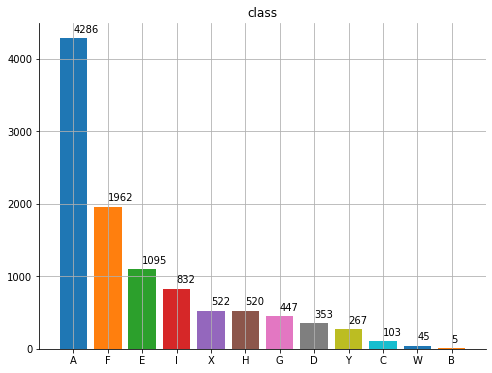

In [99]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (8, 6))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()
    
plot_single_categorical(avila_test, 'class')

The graph above shows that there are much more samples with target label 'A' than any other ones. 
The number of label 'A' samples is more than twice the one with label 'F', which is the second most.

In [100]:
avila_test = pd.get_dummies(data = avila_test, columns = ['class'])

In [101]:
avila_test.columns

Index(['intercolumnar distance', 'upper margin', 'lower margin',
       'exploitation', 'row number', 'modular ratio', 'interlinear spacing',
       'weight', 'peak number', 'modular ratio/ interlinear spacing',
       'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F',
       'class_G', 'class_H', 'class_I', 'class_W', 'class_X', 'class_Y'],
      dtype='object')

In [102]:
avila_test['class_A'] = avila_test['class_A'].astype(str)

In [113]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    print(f"ratio of quantity in label 'A' samples to other samples: {round(df[col].value_counts()[1]/df[col].value_counts()[0], 2)}")
    plt.show()

ratio of quantity in label 'A' samples to other samples: 0.7


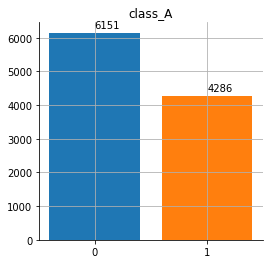

In [114]:
plot_single_categorical(avila_test, 'class_A')

The graph above shows that the number of samples with label 'A' is less than half in the whole dataset. 

The ratio of quantity in label 'A' samples to other samples is 7:10.

In [116]:
X = avila_test[['exploitation']]
y = avila_test['class_A'].astype(int)

Load model to predict the target with the data in feature 'exploitation'

In [117]:
knn = joblib.load('knn.joblib')
y_pred = knn.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6151
           1       1.00      1.00      1.00      4286

    accuracy                           1.00     10437
   macro avg       1.00      1.00      1.00     10437
weighted avg       1.00      1.00      1.00     10437



Outcome: 

Among the 10437 samples which the model has never seen, every single target label has been predicted correctly by the model with a full mark measured by both 'precision' and 'recall'.